# A Timeseries Look at the Spread of Coronavirus in the US

![Final Map from QGIS made on 2020-03-19](https://i.imgur.com/GpwCA6J.gif)

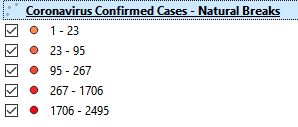

The time series data begins by showing actual locations that are effected but in early March begins to only show the cases per state. Made in QGIS with the Timemanager Plugin.

We begin by importing the required python packages that we'll need to convert the data into a format we can use in GIS.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

Next, we'll import our data from github from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series We're looking at the confirmed cases CSV file. This is the same data that is being used in the Johns Hopkins University Dashboard.

Credits for the data can be found at https://github.com/CSSEGISandData/COVID-19

In [2]:

data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

HTTPError: HTTP Error 404: Not Found

In [8]:
data = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

HTTPError: HTTP Error 404: Not Found

For our purposes we want to filter it down to just US and US Territory Cases. This same method can be used to filter for any territory or just remove this step and look at it for the whole world. We can then take a look at our dataframe to evaluate next steps. 

In [3]:
data = data[(data['Country/Region']=='US')]
data

NameError: name 'data' is not defined

We need to convert the data from columnar dates to rows. We create an index on Province/State, Country/Region, and the Lat and Long fields and then stack the data so that we duplicate locations for each date - value pair.

In [ ]:
data.set_index(['Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
converted_data = data.stack().reset_index()
converted_data

Then, we need to handle the dates. The date format wasn't working for me in QGIS (using the Timemanager plugin) or for Mapbox tiles, so we convert. Probably not great looking python but I apply a lambda function over the 'level_4' column that contains the poorly formatted dates where I split the dates by '/' and concatenate them into a string. Then I use the pandas timestamp function to convert them into Timestamps.

In [ ]:
converted_data['date'] = converted_data['level_4'].apply(lambda x: pd.Timestamp('20' + x.split('/')[2] + '-' + x.split('/')[0] + '-'+ x.split('/')[1])) 

Now we bring in geopandas to make this geographic.

In [ ]:
geo_data = gpd.GeoDataFrame(converted_data, geometry=gpd.points_from_xy(converted_data.Long, converted_data.Lat))
geo_data

Now let's clean up the column names and get ready for export to geojson. Here we're cleaning up the earlier column names from the reindexing and converting the date into a Unix epoch. Finally, we're exporting it as a geojson file.

In [ ]:
geo_data.rename(columns={'Province/State':'state', 'Country/Region': 'country', 'Lat': 'lat', 'Long':'long', 'level_4': 'odate', 0:'value'}, inplace=True)
geo_data['date'] = geo_data['date'].astype(np.int64)
geo_data.to_file('corona-us.geojson', driver='GeoJSON')